In [133]:
!pip install wandb
import json
!pip install ndjson
!mkdir -p quickdraw_data
import os
import wandb
import ndjson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [134]:
# Les 10 premières catégories disponibles dans le dataset
categories = [
    "donut", "airplane", "angel", "axe", "banana",
    "bridge", "cup", "apple", "door", "mountain"
]

# Création du dossier de données
os.makedirs("quickdraw_data", exist_ok=True)

# Téléchargement automatique via wget
for category in categories:
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/simplified/{category}.ndjson"
    filename = f"quickdraw_data/{category}.ndjson"
    if not os.path.exists(filename):
        print(f"Téléchargement : {category}")
        !wget -q -O {filename} {url}
    else:
        print(f"Déjà téléchargé : {category}")


Déjà téléchargé : donut
Déjà téléchargé : airplane
Déjà téléchargé : angel
Déjà téléchargé : axe
Déjà téléchargé : banana
Déjà téléchargé : bridge
Déjà téléchargé : cup
Déjà téléchargé : apple
Déjà téléchargé : door
Déjà téléchargé : mountain


In [135]:
#Parser et convertir les 1000 premiers dessins reconnus des 10 catégories déjà téléchargées (en .ndjson)
# en images 28x28, et les stocker dans deux arrays : images (numpy) et labels (str).

# Fonction pour convertir un dessin (strokes) en image PIL 28x28
def draw_strokes(drawing, size=28, lw=3):
    img = Image.new("L", (256, 256), color=0)  # 256x256 pour avoir de la marge
    draw = ImageDraw.Draw(img)

    for stroke in drawing:
        points = list(zip(stroke[0], stroke[1]))
        draw.line(points, fill=255, width=lw)

    img = img.resize((size, size), Image.Resampling.LANCZOS)
    return np.array(img)


# Parser et convertir les 100 premiers dessins reconnus
images = []
labels = []

for category in categories:
    path = f"quickdraw_data/{category}.ndjson"
    try:
        with open(path) as f:
            data = ndjson.load(f)
    except FileNotFoundError:
        print(f"Fichier manquant pour {category}, ignoré.")
        continue

    count = 0
    for sample in data:
        if sample["recognized"]:
            img = draw_strokes(sample["drawing"])
            images.append(img)
            labels.append(category)
            count += 1
        if count >= 1000:  # Load 1000 samples per category
            break

images = np.array(images)
labels = np.array(labels)

print("Total images :", images.shape)
print("Total labels :", labels.shape)

Total images : (10000, 28, 28)
Total labels : (10000,)


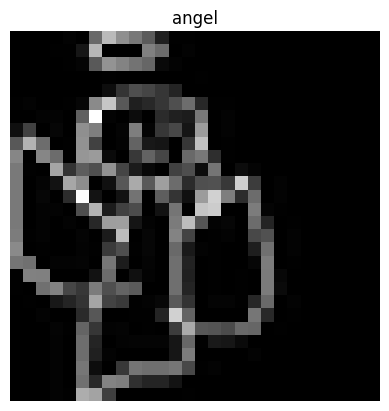

In [136]:
#Visualisez une image random
import random

idx = random.randint(0, len(images) - 1)
plt.imshow(images[idx], cmap="gray")
plt.title(labels[idx])
plt.axis("off")
plt.show()

In [137]:
# Normalisation : on ramène les valeurs des pixels entre 0 et 1
images = images.astype("float32") / 255.0
images = np.expand_dims(images, axis=1)  # PyTorch : (N, 1, 28, 28)

# Encodage des labels (ex: 'cat' -> 3, 'dog' -> 5, etc.)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print("Catégories encodées :", list(label_encoder.classes_))
print("Nombre de classes :", len(label_encoder.classes_))


# Split des données
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Conversion en tenseurs
X_train = torch.tensor(X_train)
X_val   = torch.tensor(X_val)
X_test  = torch.tensor(X_test)

y_train = torch.tensor(y_train)
y_val   = torch.tensor(y_val)
y_test  = torch.tensor(y_test)

# Création des datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

# Création des DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

print("Données prêtes pour l'entraînement.")

#On a 8 classes alors qu'on devrait en avoir 10 il faut donc prendre la variable "classes" dans le modèle CNN pour être sûr de ne pas avoir des classes des fichiers .ndjson sont en erreur

Catégories encodées : [np.str_('airplane'), np.str_('angel'), np.str_('apple'), np.str_('axe'), np.str_('banana'), np.str_('bridge'), np.str_('cup'), np.str_('donut'), np.str_('door'), np.str_('mountain')]
Nombre de classes : 10
Données prêtes pour l'entraînement.


In [138]:
# CNN simple avec PyTorch, inspiré de LeNet-5, adapté aux images 28×28 en niveaux de gris
class BetterCNN(nn.Module):
    def __init__(self, num_classes):
        super(BetterCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32, 14, 14)
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64, 7, 7)
            nn.Dropout(0.5),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = BetterCNN(num_classes=len(label_encoder.classes_))

In [139]:
# Transforme les tableaux images et labels en un Dataset PyTorch, puis les séparer en train, val et test

class QuickDrawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
               transforms.ToPILImage(),
               transforms.RandomRotation(10),  # Rotation aléatoire de 10 degrés
               transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation aléatoire
               transforms.ToTensor()
           ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # The line below was causing the problem
        # image = torch.tensor(image).unsqueeze(0)  # Shape: (1, 28, 28)
        # We already have (1, 28, 28) from previous operations
        image = torch.tensor(image)  # Keep the original image shape (1, 28, 28)
        label = torch.tensor(label).long()

        if self.transform:
            image = self.transform(image)

        return image, label


In [140]:
# Séparation train/val/test

# Encodage des labels texte en entiers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Split 80% train, 10% val, 10% test
# Use labels_np instead of labels_encoded for stratify
X_train, X_temp, y_train, y_temp = train_test_split(images, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 8000, Val: 1000, Test: 1000


In [141]:
# Création des DataLoader
batch_size = 64

train_dataset = QuickDrawDataset(X_train, y_train)
val_dataset = QuickDrawDataset(X_val, y_val)
test_dataset = QuickDrawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [142]:
# Initialisation de l’entraînement - Définir modèle, loss et optimizer
model = BetterCNN(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)  # Reduce LR if val loss plateaus

In [143]:
# Intégration avec Weights & Biases - Initialisation wandb

wandb.init(project="quickdraw-cnn", config={
    "architecture": "BetterCNN",
    "dataset": "QuickDraw (20 classes)",
    "epochs": 10,
    "batch_size": batch_size,
    "learning_rate": 1e-3
})

wandb.watch(model, log="all")

In [144]:
# boucle entrainement

best_val_acc = 0
patience = 2
wait = 0

train_accs, val_accs = [], []

for epoch in range(20):
    model.train()
    correct = total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100 * correct / total
    train_accs.append(train_acc)

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100 * correct / total
    val_accs.append(val_acc)

    print(f"[{epoch+1}/20] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

[1/20] Train Acc: 64.59% | Val Acc: 81.20%
[2/20] Train Acc: 80.70% | Val Acc: 87.40%
[3/20] Train Acc: 84.29% | Val Acc: 88.50%
[4/20] Train Acc: 86.04% | Val Acc: 90.40%
[5/20] Train Acc: 87.20% | Val Acc: 90.10%
[6/20] Train Acc: 87.15% | Val Acc: 90.70%
[7/20] Train Acc: 86.90% | Val Acc: 91.10%
[8/20] Train Acc: 86.69% | Val Acc: 90.40%
[9/20] Train Acc: 86.84% | Val Acc: 90.70%
Early stopping.


In [145]:
# Évaluation sur le test set

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
wandb.log({"test_acc": test_acc})

# fonction d’affichage de courbes

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()
    plt.show()


Test Accuracy: 90.40%


In [146]:
#  Sauvegarde du modèle entraîné (.pth)

model_path = "quickdraw_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Modèle sauvegardé dans {model_path}")

Modèle sauvegardé dans quickdraw_cnn.pth


In [147]:
# Arrêt du tracking Weights & Biases

wandb.finish()

test_acc,▁
test_acc,90.4
